In [1]:
import pymc3 as pm 
import matplotlib.pyplot as plt
import numpy as np 
import theano
import theano.tensor as tt
from scipy import stats
import pymc3 as pm 
from ipynb.fs.full.simul_data import *
from ipynb.fs.full.counterfactual_generate import *
a_dim=7
mu_a = np.zeros(a_dim)
cov_a = np.eye(a_dim)

num_samples =100
trans_dim = 6
u_dim = 3
rating_dim = 5
N=100
mu_u = np.zeros(u_dim)
cov_u = np.eye(u_dim)
mu_trans = np.zeros(trans_dim)
cov_trans = np.eye(trans_dim)
mu_rating = np.zeros(rating_dim)
cov_rating = np.eye(rating_dim)

In [2]:

causal_model = model1(u_dim,trans_dim,rating_dim)
data = causal_model.generate(num_samples)

print("transcript shape ",data["transcript"].shape)
print("view shape ",data["view"].shape)
print("a shape ",data["a"].shape)
print("rating shape ",data["rating"].shape)
# mu_rand = np.random.normal(size=10)

transcript shape  (100, 6)
view shape  (100,)
a shape  (100, 7)
rating shape  (100, 5)


In [16]:
def model_fit(data,method='mcmc'):

    with pm.Model() as model:

        #prior sampling
        u = pm.MvNormal('u',mu=mu_u,cov=cov_u,shape=u_dim)
        transcript0 = pm.MvNormal('transcript0',mu=mu_trans,cov=cov_trans,shape=trans_dim)
        view0 = pm.Normal('view0',mu=0,tau=1)

        #effect of u 
        eta_u_transcript = pm.MatrixNormal('eta_u_transcript',colcov=cov_u, rowcov=cov_trans, shape=(trans_dim, u_dim))
        eta_u_view = pm.MvNormal('eta_u_view',mu=mu_u,cov=cov_u,shape=u_dim)
        eta_u_rating = pm.MatrixNormal('eta_u_rating',colcov=cov_u, rowcov=cov_rating, shape=(rating_dim, u_dim))

        #effect of protected attribute
        eta_a_transcript = pm.MatrixNormal('eta_a_transcript',colcov=cov_trans, rowcov=cov_a, shape=(a_dim, trans_dim))
        eta_a_view = pm.MvNormal('eta_a_view',mu=mu_a,cov=cov_a,shape=a_dim)
        eta_a_rating = pm.MatrixNormal('eta_a_rating',colcov=cov_rating, rowcov=cov_a, shape=(a_dim,rating_dim))

        #effect of transcript on view and rating
        eta_transcript_view = pm.MvNormal('eta_transcript_view',mu=mu_trans,cov=cov_trans,shape=trans_dim)
        eta_transcript_rating = pm.MatrixNormal('eta_transcript_rating',colcov=cov_rating, rowcov=cov_trans, shape=(trans_dim,rating_dim))

        #effect of view on rating
        eta_view_rating = pm.MvNormal('eta_view_rating',mu=mu_rating,cov=cov_rating,shape=rating_dim)


        sigma_transcript_sq = pm.InverseGamma('sigma_transcript_sq',alpha=1,beta=1)
        sigma_rating_sq = pm.InverseGamma('sigma_rating_sq',alpha=1,beta=1)
        print(data['a'].shape)
        
        transcript_mean =   tt.dot(eta_u_transcript ,u)+transcript0 + tt.dot(data['a'] , eta_a_transcript)
        transcript = pm.MvNormal('transcript', mu= transcript_mean, cov = sigma_transcript_sq*np.eye(trans_dim), observed = data["transcript"] )
        
        
        view_mean = tt.exp(view0 + tt.dot(eta_u_view , u)+   tt.dot(data['a'],eta_a_view)+tt.dot(transcript, eta_transcript_view)) 
        view = pm.Poisson('view',mu =view_mean, observed = data['view'] )

        rating_mean = tt.dot(eta_u_rating , u) +  tt.dot(data['a'],eta_a_rating) + tt.dot(transcript, eta_transcript_rating) + tt.dot(tt.reshape(view,(-1,1)), tt.reshape(eta_view_rating,(1,-1))) 
        rating = pm.Normal('rating', mu= rating_mean, sd = sigma_rating_sq, observed = data["rating"] ) 
        
        if method == 'mcmc':        
            trace=pm.sample(100,init='advi',target_accept=0.8)
        elif method == 'vi':
            trace=pm.fit()
        else:
            print('Not Implemented any other method')
            return
            
    return trace
    

In [ ]:
trace = model_fit(data)

(100, 7)


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 53,786:  35%|███▍      | 69172/200000 [03:32<05:50, 373.43it/s]    
Convergence achieved at 69200
Interrupted at 69,199 [34%]: Average Loss = 1.9865e+15
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_rating_sq, sigma_transcript_sq, eta_view_rating, eta_transcript_rating, eta_transcript_view, eta_a_rating, eta_a_view, eta_a_transcript, eta_u_rating, eta_u_view, eta_u_transcript, view0, transcript0, u]
Sampling 2 chains:  60%|██████    | 724/1200 [11:55<11:26,  1.44s/draws]

In [ ]:
u_list = counterfactual_sample(data,trace)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c222cfef0>,
      dtype=object)

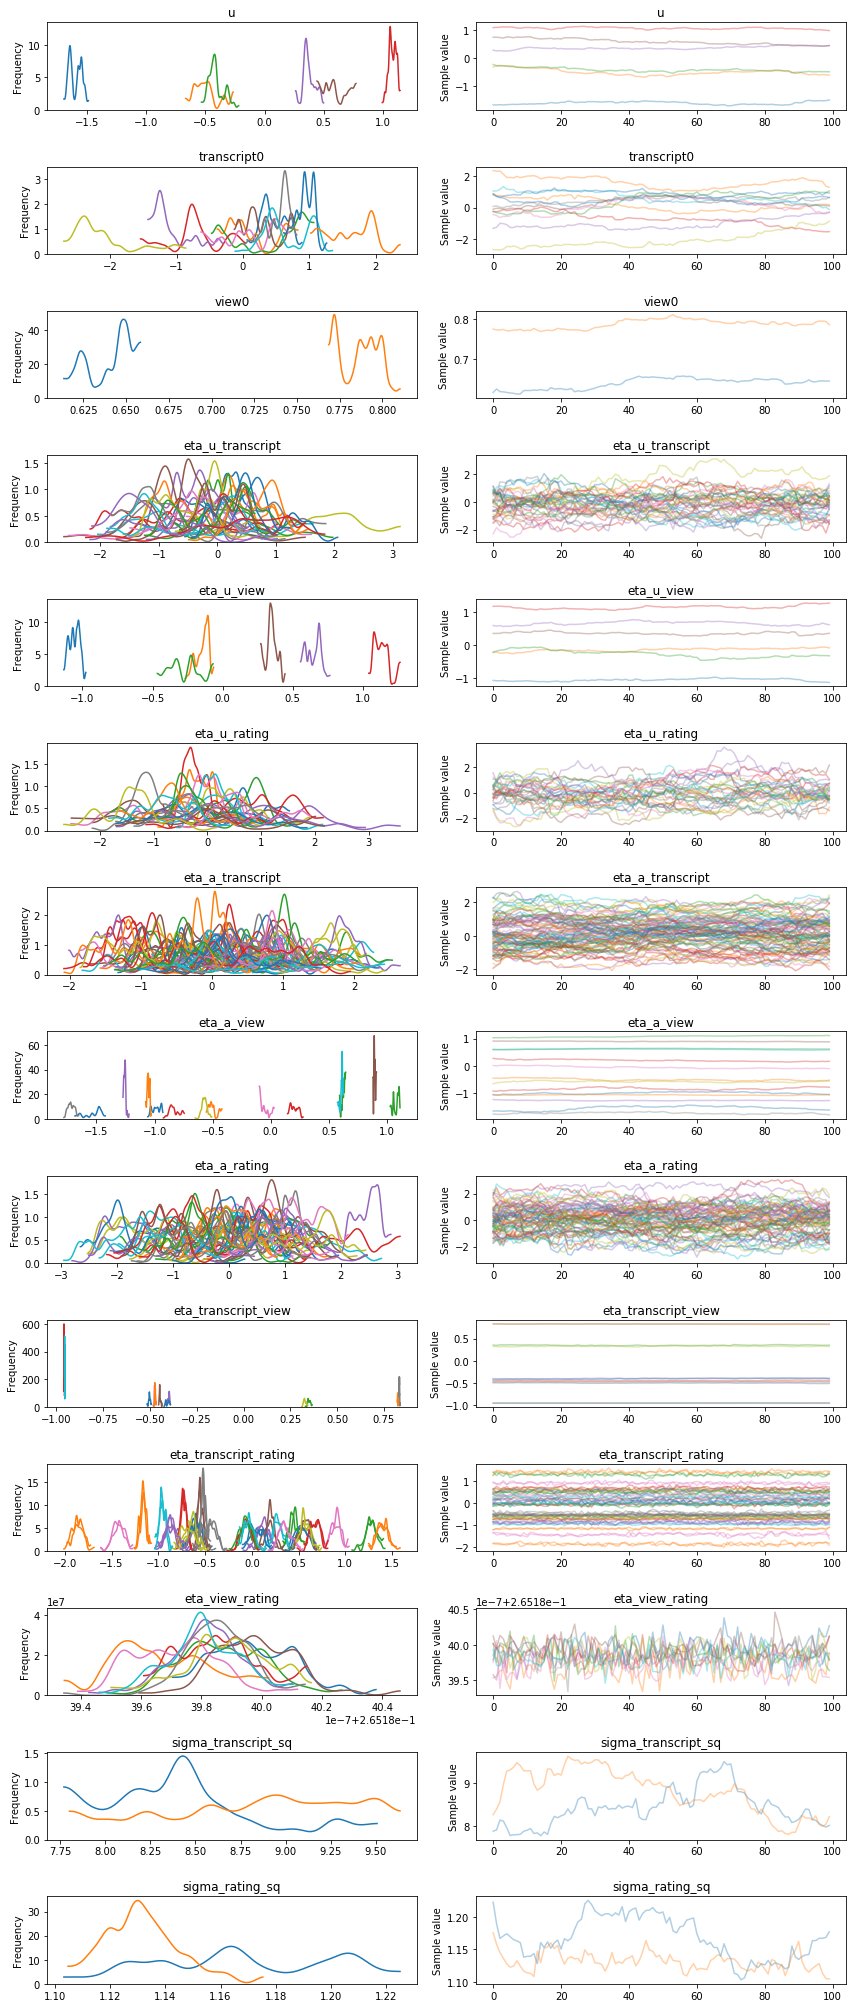

In [15]:
pm.traceplot(trace)

In [ ]:
trace